## Sentiment Analysis
Prepared by Amr Mohamed on 11/18/2019

The purpose of the project is to train multiple classifiers to predict the sentiment of generic tweets, and then use the best classifier to evaluate how natural language processing (NLP) can help us in the prediction of the sentiment of tweets covering political elections, and to predict outcomes of elections. Furthermore, a classifier is trained to predict the negative reasons behind negative political tweets to further study the helpfulness of NLP techniques in covering political elections.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from bs4 import BeautifulSoup
import re
import string
from wordcloud import WordCloud

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## 1. Text Cleaning

In this section, we clean the tweets which have been web-scraped from twitter. We will remove html characters, codes, punctuation symbols, twitter handles, links and numbers from tweets. We will lower case the tweet. We will use the lemmatizer from NLTK library to stem the words. Whilst much slower than using a porter stemmer, the lemmatizer will return us a valid word from the English vocabulary for every word we run through it, which will help us with the word data visualizations in the next section.

The stop words will be imported from the txt file provided by the course staff.

Lastly, we will create a separate column for the hashtags in each tweet.

In [2]:
lemmatizer = WordNetLemmatizer()

f = open("stop_words.txt", "r")
stop_words = re.split('\n \t',f.read())

In [3]:
def get_wordnet_pos(w):
    ''' this function helps the lemmatizer identify the part of speech
    of a given word so that it is stemmed appropriately
        input: word (string)
        output: part-of-speech of word
    '''
    pos = nltk.pos_tag([w])[0][1][0].upper()
    pos_dict = {"J": wordnet.ADJ,"N": wordnet.NOUN,"V": wordnet.VERB,"R": wordnet.ADV}
    return pos_dict.get(pos, wordnet.ADV)

def clean_tweet(s):
    '''
        input: s sentence as a string
        output: cleaned sentence
    '''    
    s = str.lower(BeautifulSoup(s).get_text()) # remove html tags and lower case
    s.replace('‘', "'").replace('’', "'").replace('“', "'").replace('”', "'") # replace any fancy apostrophes
    s = re.sub(r'@[A-Za-z0-9]+', '', s) # remove twitter handles '@...'
    s = s.replace('b"','').replace('b\'','') # remove twitter beginnings 'b'...'
    s = re.sub('https?://[A-Za-z0-9./]+', '', s) # remove links
    s  = "".join([char for char in s if char not in '!"$%&#()*+,-./:;<=>?@[\\]^_`{|}~\n\t\v\b']) # remove punctuation 
    s = re.sub('[0-9]+', '', s) # remove numbers
    s = nltk.word_tokenize(s) # tokenize
    s = [w.replace('\'', '') for w in s] # remove remaining apostrophes
    s = [w for w in s if w not in stop_words]  # remove stop words
    s = [w for w in s if len(w)>2] # remove single and double character strings if any
    s = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in s] # lemmatize words   
    s = ' '.join(s) # join words to make sentence again
    #s = ' '.join([w for w in s if w not in stop_words]) # an additional check for stop words
    
    return s

In [4]:
df = pd.read_csv('Canadian_elections_2019.csv') # importing the Canadian election tweets csv file
clean_text = [clean_tweet(s) for s in df.text] # cleaning the tweets
hashtags = [re.findall(r'#[A-Za-z0-9]+', s) for s in df.text] # seperating hashtags

df['tweet'] = clean_text
df['hashtag'] = hashtags

We will export the cleaned data as a csv file so that we can import it later faster. 

In [5]:
dfelect = df

We will do the same thing for the generic tweets.

**Note: Cleaning the generic tweets will take relatively long to process** 

In [6]:
df = pd.read_csv('generic_tweets.txt')
clean_text = [clean_tweet(s) for s in df.text]

df['tweet'] = clean_text

In [7]:
dftweet = df

In [8]:
del df, lemmatizer, stop_words, clean_text, hashtags

f.close()

### Importing clean generic tweets

In [9]:
dftweet = dftweet.drop(columns=list(set(dftweet.columns).difference(set(['class', 'tweet']))))

In [10]:
pd.set_option('display.max_colwidth', -1)
dftweet.head()

,class,tweet
0,0,awww that bummer you shoulda get david carr third day
1,0,upset that update his facebook texting and might cry result school today also blah
2,0,dive many time for the ball manage save the rest out bound
3,0,whole body feel itchy and like its fire
4,0,not behaving all mad why here because see you all over there


### Importing clean Canadian elections tweets

In [12]:
dfelect = dfelect.drop(columns=['text'])

In [13]:
dfelect['negative_reason'] = dfelect['negative_reason'].fillna('Others')
dfelect.head()

,sentiment,negative_reason,tweet,hashtag
0,negative,Women Reproductive right and Racism,instead your suggestion how about agree that canadian woman can not and should not trust that andrewscheer and conservative government will protect woman right have automony over her body let with that cdnpoli elxn canada abortion,"[#Canadian, #women, #AndrewScheer, #Conservatives, #cdnpoli, #elxn43, #Canada, #abortion]"
1,positive,Others,allwomanspacewalk realnstation netobicokenorth cityofto onpoli cdnpoli elxn,"[#AllWomanSpacewalk, #EtobicokeNorth, #CityofTO, #ONPoli, #cdnpoli, #elxn43]"
2,negative,Economy,brantford go cost you billion for the next year ask justin elxn cdnpoli canada,"[#Brantford, #elxn43, #cdnpoli, #Canada]"
3,positive,Others,canada canadaelection canadavotes nelxn nnca decide this should helpnn,"[#Canada, #CanadaElection2019, #CanadaVotes, #elxn43]"
4,negative,Economy,canada taxpayer be sick tire have their hard earn donate corporate welfare bum that need this only one many reason trudeaumustgo can leave canada for all care copps snclavalinscandal election elxn cdnpoli,"[#Canada, #taxpayers, #TrudeauMustGo, #Canada, #SNCLavalinScandal, #Election2019, #elxn43, #cdnpoli]"


## 2. Exploratory Analysis

In this section, we will engineer a new feature determining the political party referenced by each tweet and perform some visual analysis of the data

### Identify political party

I chose to identify the party from the hashtags. To aid with assessing the hashtags most used, below is a wordcloud with all hashtags which we can study to identify the hashtags that people used to post about a political party. The hashtags that are affiliated with a specific party will be used in the identify_party() function to tag each tweet with a party. 

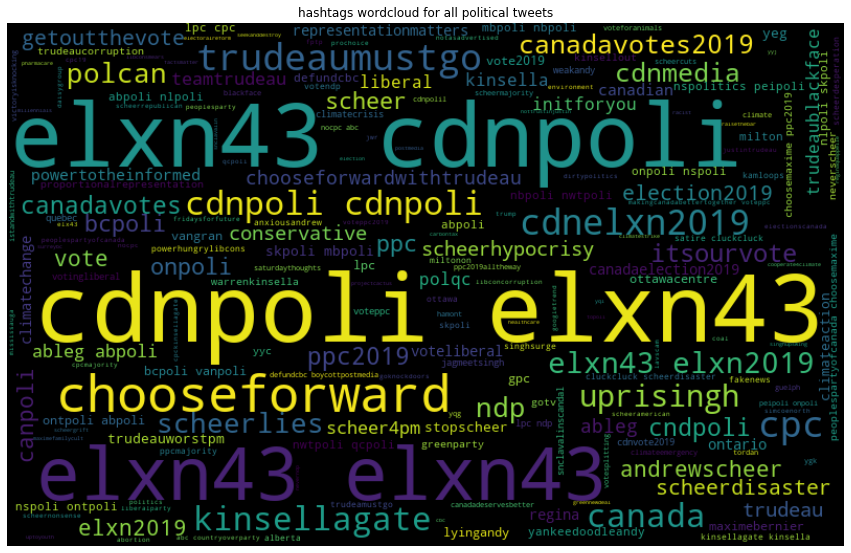

In [62]:
all_hashtags = (' '.join(dfelect['hashtag'].astype(str))).replace('[', '').replace(']', '').replace('\'', '').replace(',', '').replace('#', '').lower()
wordcloud = WordCloud(width=800, height=500, random_state=0).generate(all_hashtags)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('hashtags wordcloud for all political tweets')
plt.axis('off')
plt.show()

In [63]:
def identify_party(s):
    '''
        input: s (tweet)
        returns the party referenced in the tweet
    '''
    lpc = ['liberal', 'justin', 'trudeau', 'lpc', 'chooseforward']
    cpc = ['conservative', 'andy', 'andrew', 'scheer', 'cpc', 'kinsella', 'warren']
    ndp = ['democratic', 'jagmeet', 'singh', 'ndp', 'initforyou']
    ppc = ['people\'s', 'maxime', 'bernier', 'ppc', 'strongandfree']
    gpc = ['green', 'gpc', 'forwardtogether']
    
    for w in lpc: 
        if w in s: return 'lpc'
    for w in cpc: 
        if w in s: return 'cpc'
    for w in ndp: 
        if w in s: return 'ndp'
    for w in gpc: 
        if w in s: return 'gpc'
    for w in ppc: 
        if w in s: return 'ppc'
    return 'other'
    

In [64]:
party = [identify_party(s) for s in dfelect.tweet]

In [65]:
dfelect['party'] = party

In [66]:
dfelect.head()

,sentiment,negative_reason,tweet,hashtag,party
0,negative,Women Reproductive right and Racism,instead your suggestion how about agree that canadian woman can not and should not trust that andrewscheer and conservative government will protect woman right have automony over her body let with that cdnpoli elxn canada abortion,"[#Canadian, #women, #AndrewScheer, #Conservatives, #cdnpoli, #elxn43, #Canada, #abortion]",cpc
1,positive,Others,allwomanspacewalk realnstation netobicokenorth cityofto onpoli cdnpoli elxn,"[#AllWomanSpacewalk, #EtobicokeNorth, #CityofTO, #ONPoli, #cdnpoli, #elxn43]",other
2,negative,Economy,brantford go cost you billion for the next year ask justin elxn cdnpoli canada,"[#Brantford, #elxn43, #cdnpoli, #Canada]",lpc
3,positive,Others,canada canadaelection canadavotes nelxn nnca decide this should helpnn,"[#Canada, #CanadaElection2019, #CanadaVotes, #elxn43]",other
4,negative,Economy,canada taxpayer be sick tire have their hard earn donate corporate welfare bum that need this only one many reason trudeaumustgo can leave canada for all care copps snclavalinscandal election elxn cdnpoli,"[#Canada, #taxpayers, #TrudeauMustGo, #Canada, #SNCLavalinScandal, #Election2019, #elxn43, #cdnpoli]",lpc


Let's look at the proportion of tweets for each party. Note that I have chosen to also consider tweets affiliated with NDP, PPC and green parties, besides the Liberal and Conservative parties. 

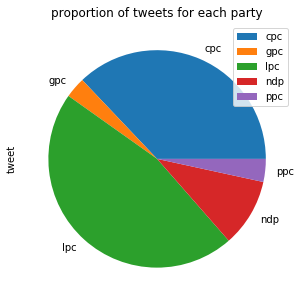

In [67]:
dfelect.groupby(dfelect.party).count().drop('other').plot.pie(y='tweet', figsize=(5, 5))
plt.title('proportion of tweets for each party')
plt.show()

We can see that most of the tweets are affiliated with the conservative and liberal parties, followed by the NDP. 

Let's now look at how many of these tweets were positive or negative for each party.

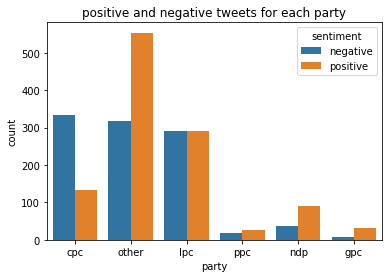

In [68]:
sns.countplot(x='party', hue='sentiment', data=dfelect)
plt.title('positive and negative tweets for each party')
plt.show()

The Liberal part has as many negative tweets as postive ones, and each of the smaller three parties have more positives than negatives. The Conservatives have more than twice negatives as positives. 

**For bonus** Let's look into the data into more detail to see why the Conservatives have such bad reputation on Twitter. Let's hue the negative sentiments with their reasons next.

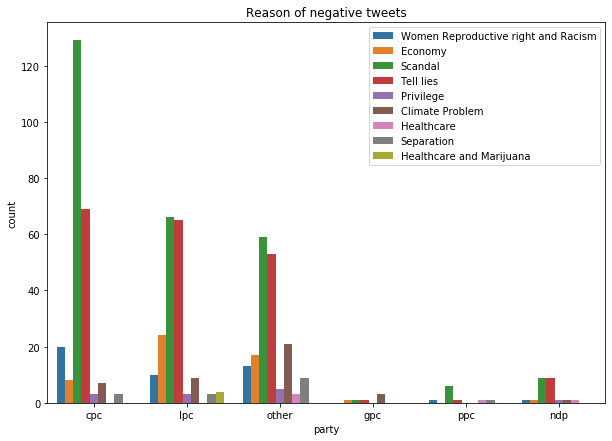

In [69]:
plt.figure(figsize=(10, 7))
sns.countplot(x='party', hue='negative_reason', data=dfelect[dfelect['sentiment'] == 'negative'][dfelect['negative_reason'] != 'Others'])
plt.legend(loc=1)
plt.title('Reason of negative tweets')
plt.show()

It looks like everyone is a liar and that is taking the focus of the elections off more important issues such as Healthcare and Economy. Liberals and Conservatives seem to be guilty of some scandals, however, the conservatives are much more guilty of it. Let's look at the main words that come out in the tweets which discuss the scandals the Conservatives are engaged in. 

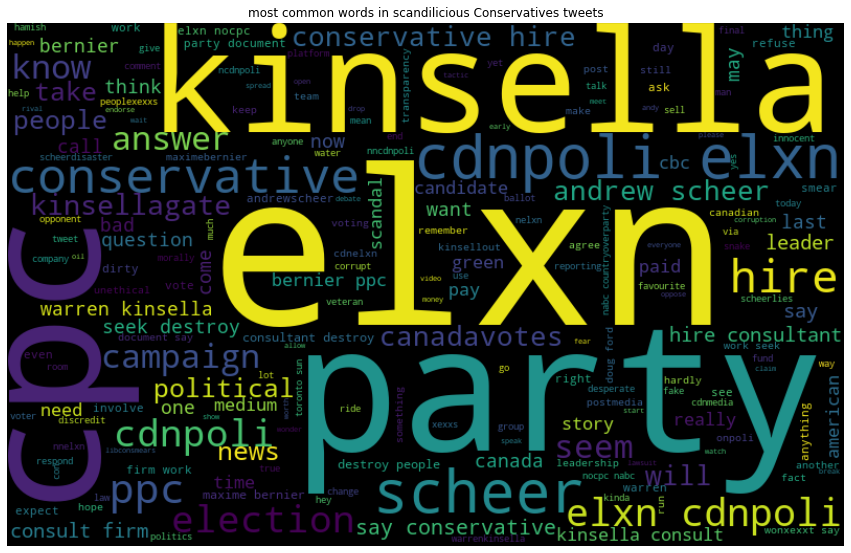

In [70]:
s = ' '.join(list(dfelect['tweet'][dfelect['negative_reason'] == 'Scandal'][dfelect['party'] == 'cpc'].fillna('')))
wordcloud = WordCloud(width=800, height=500, random_state=0).generate(s)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('most common words in scandilicious Conservatives tweets')
plt.axis('off')
plt.show()

The KinsellaGate Scandal! 

It is actually very nice how data analysis of the tweets have highlighted this issue right away so early on. One can trace the story very well from this cloud. The *conservatives*' *scheer* *hire*d *warrenkinsella* *seek*ing to *destroy* *bernier*'s *ppc*. All the italicized words are extracted from the word cloud. 

From this, I have gone up to add kinsella hashtags to the function identifying cpc as the tweet affiliated political party.

### Preliminary data visualization

Let's look at the wordcloud of the words mentioned in negative and positive tweets and discuss any differences.

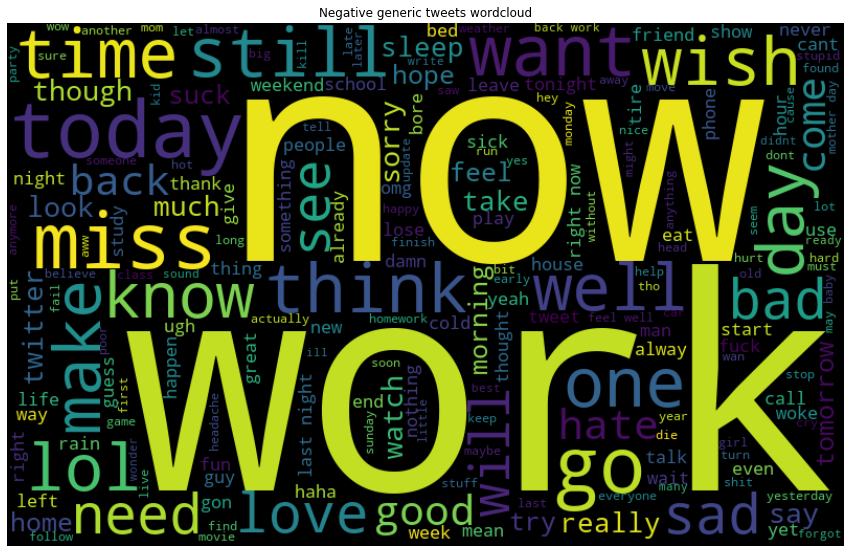

In [71]:
s = (' '.join(list(dftweet['tweet'][dftweet['class'] == 0].fillna(''))))
wordcloud = WordCloud(width=800, height=500, random_state=0).generate(s)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative generic tweets wordcloud')
plt.show()

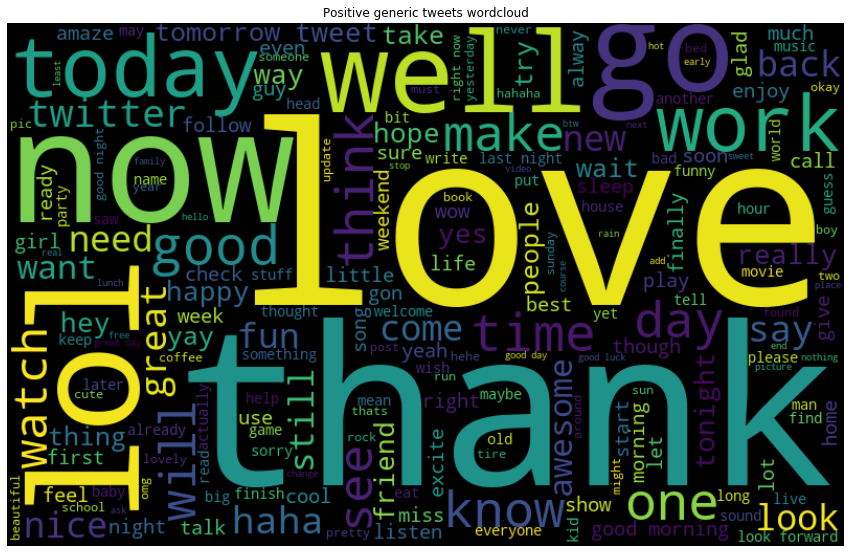

In [72]:
s = ' '.join(list(dftweet['tweet'][dftweet['class'] == 4].fillna('')))
wordcloud = WordCloud(width=800, height=500, random_state=0).generate(s)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive generic tweets wordcloud')
plt.show()

The largest words like *love* and *good* are mentioned very frequently in all tweets, positive or negative, and as such can be seen taking a large space in both wordclouds. Its the smaller words like *suck*, *tire* and *sick* which are associated with negative sentiment, and *happy*, *cute*, and *hope* which are associated with positives. 

It is funny how *morning* is more associated with negative sentiment and *night* is more associated with positive. We're a society of night owls!

The wordclouds help us gain some insight over what words are likely to be in positive and negative tweets.

Let's see if the words associated with positive tweets are also frequent in positive tweets covering the elections.

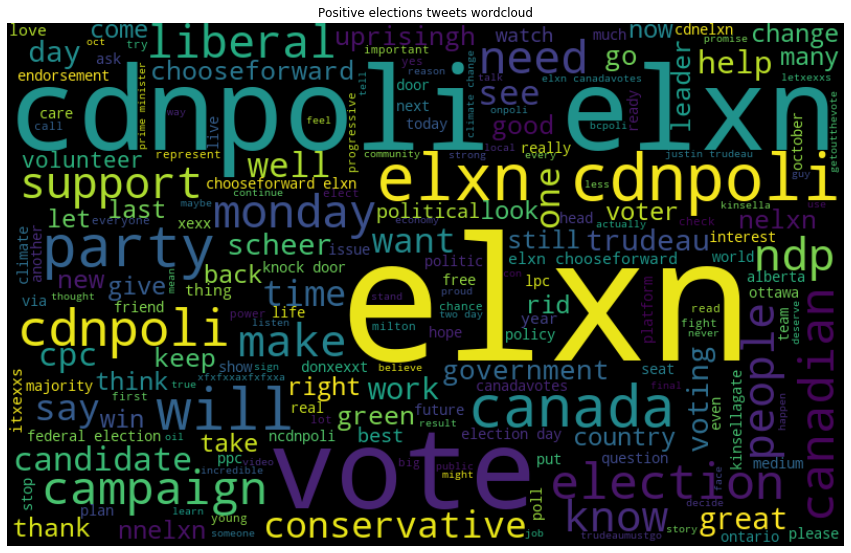

In [73]:
s = ' '.join(list(dfelect['tweet'][dfelect['sentiment'] == 'positive'].fillna('')))
wordcloud = WordCloud(width=800, height=500, random_state=0).generate(s)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Positive elections tweets wordcloud')
plt.axis('off')
plt.show()

So the elections tweets, understandably, have words that are just not used day-to-day, making the positive tweets wordclouds of the different datasets remarkably distinct. If we train the classifier on generic tweets, it will filter out the elections specific words, and use the day-to-day words discussed in the previous wordcloud. Fortunately, we can see that the wordcloud still shares some positively-associated words such as *love*, *great* and *win*, which might make our classifiers work to some extent. 

## 4. Text Encoding

We will use bag-of-words and TF-IDF text encoding in the rest of the assignment. This section just define functions for later use. The functions return the feature numerical matrices per the text encoding techniques.

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Bag-of-words text encoding

In [75]:
def bagofwords(df):
    vectorizer = CountVectorizer(min_df=0.001, max_df=0.6)
    X = vectorizer.fit_transform(df.tweet.fillna(''))
    X = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
    return X

### TF-IDF text encoding

In [76]:
def tfidf(df):
    vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.6)
    X = vectorizer.fit_transform(df.tweet.fillna(''))
    X = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
    return X

## 5. Model Preparation

In this section, we compare between different classification models. Our test set are the generic tweets and the labels are their sentiments (positive or negative). We test out Logisitic Regression (LR), Support Vector Machines (SVM), Decision Trees (DT), Random Forests (RF), AdaBoost ensemble (Ada), Naive Bayes (NB), k-Nearest Neighbor (kNN), and - **for bonus** - deep multi-layer perceptrons (MLP). 

**For bonus**, we will perform model parameter tuning on each classifier using a validation set. We also run the test using both methods of text encoding discussed in the previous section. We will then use the best model to predict sentiments of political tweets in the next section. 

Most of the section has been commented to avoid long wait times for processing. The accuracy scores of the different models have been marked down. 

In [77]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

In [78]:
y = dftweet['class']

### Training on Bag-of-Words

In [79]:
new_dict = {'LR': 70.9725, 'SVM': 70.8615, 'DT': 65.7286, 'RF': 67.6456, 
            'NB': 69.5866, 'Ada': 70.18659, 'MLP': 69.7696, 'kNN': 66.8176, 'XG': 69.89}
new_dict = pd.DataFrame(index=new_dict.keys(), data=list(new_dict.values()), columns=['accuracy'])
new_dict = new_dict.sort_values('accuracy', ascending=False)

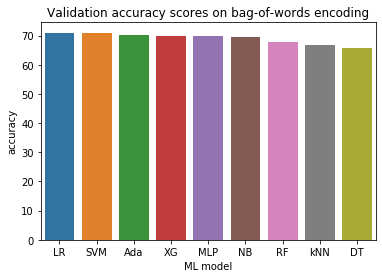

In [80]:
sns.barplot(data=new_dict, y='accuracy', x=new_dict.index)
plt.title('Validation accuracy scores on bag-of-words encoding')
plt.xlabel('ML model')
plt.show()

### Training on TF-IDF

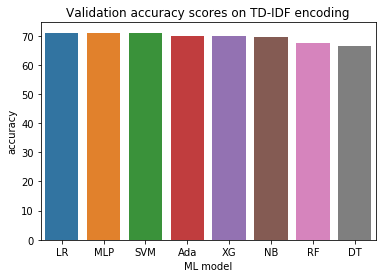

In [82]:
new_dict = {'LR': 71.0115, 'SVM': 70.9005, 'DT': 66.35567, 'RF': 67.4206, 
            'NB': 69.5656, 'Ada': 69.880, 'MLP': 70.9575, 'XG': 69.8356}
new_dict = pd.DataFrame(index=new_dict.keys(), data=list(new_dict.values()), columns=['accuracy'])
new_dict = new_dict.sort_values('accuracy', ascending=False)
sns.barplot(data=new_dict, y='accuracy', x=new_dict.index)
plt.title('Validation accuracy scores on TD-IDF encoding')
plt.xlabel('ML model')
plt.show()

**For bonus** We have plotted the accuracy score for the different text encoding techniques for all models under study. Note that we have dropped kNN in the TF-IDF due to its very slow processing. Even if better than the others, its slow processing would have deemed it unfit for use on an application requiring quick prediction. This is ofcourse since the distance to each instance in the training set needs to be computed for each testing instance during prediction. 

In both, LR was the best model with a very slight advantage over the next. In bag of words (BoW), SVM came second right after. In TF-IDF, MLP came second. The surprising thing is that the best model for MLP from the model parameter tuning had only 25 hidden layers. More layers contributed higher overfit and were less superior than the shallow 25 layer one. LR, SVM and 25 layer MLP, all had very fast computational times.

Unexpectedly, DTs came last in each test. 

The best model is the LR model with C=1 and L2 penalty when TF-IDF is used. The accuracy score on the validation set is 71%.

We will use LR in the next section to test whether a classifier trained on predicitng sentiment of generic tweets can be used during the election period.


## 6. Model Implementation

In this section, we'll apply the LR model from last section to predict the sentiment of political tweets. This requires us to TF-IDF vectorize the generic tweets data, and train the LR classifier on it. Following that, we TF-IDF vectorize the political tweets data only using the features identified during vectorizing the generic tweets. This effectively ignores the new words that are in the political tweets dataset that were not frequent in the generic tweets dataset. This is what I had mentioned above during data visualization. The model will only classify political tweets on the basis of day-to-day words that are used in generic tweets.

In [83]:
vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.6)
X = vectorizer.fit_transform(dftweet.tweet.fillna(''))
X_train = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
y_train = y

In [84]:
clf = LogisticRegression(penalty='l2', dual=False, 
                             tol=0.0001, C=1, fit_intercept=True, 
                             intercept_scaling=1, class_weight=None, 
                             random_state=43, solver='liblinear', max_iter=100, 
                             multi_class='auto', verbose=0, warm_start=False, 
                             n_jobs=None, l1_ratio=None)
clf.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=43, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
y_pred = clf.predict(X_train)
print('training accuracy: {}%'.format(accuracy_score(y_train, y_pred)*100))

training accuracy: 76.134%


In [86]:
vectorizer = TfidfVectorizer(vocabulary=vectorizer.get_feature_names())
X = vectorizer.fit_transform(dfelect.tweet.fillna(''))
X_test = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
y_test = [4*int(s == 'positive') for s in dfelect.sentiment]

In [87]:
y_pred = clf.predict(X_test)
print('test accuracy: {}%'.format(accuracy_score(y_test, y_pred)*100))

test accuracy: 59.962494139709335%


In [88]:
dfelect['y_true'] = y_test

In [89]:
dfelect['y_pred'] = y_pred

The training accuracy of the model on the generic tweets is 71.3% and the test accuracy on the political tweets is 57.9%. We have correctly classifier 57.9% of the political tweets correctly as negative or positive.

## 7. Sentiment Prediction Results

In this section, we'll just visualize the political tweet sentiment results, answer the research questions and discuss any interpretations. 

In [90]:
from sklearn.metrics import confusion_matrix

In [91]:
cm = confusion_matrix(y_test,y_pred)

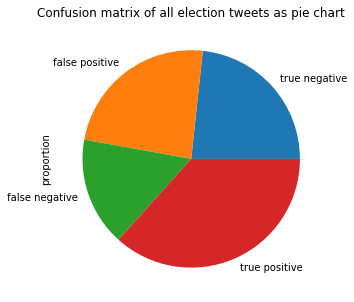

In [92]:
pd.DataFrame(data=cm.reshape(-1,1), index=['true negative', 'false positive', 'false negative', 'true positive'], 
             columns=['proportion']).plot.pie(y='proportion', figsize=(5, 5), legend=False)
plt.title('Confusion matrix of all election tweets as pie chart')
plt.show()

The pie chart above visualizes the confusion matrix of running the classifier on the political tweets dataset. One thing to notice is that the classifier is skewed in the sense that it is more likely to label a tweet as positive. Again, this might be due to the fact that day-to-day words that are associated with negative sentiment are not the same that are used to associate negative sentiments with a political party. Let's see if we can support this hypothesis next.

Let's study the prediction accuracy across different parties. 

CPC test accuracy: 52.77777777777778%
LPC test accuracy: 57.534246575342465%
NDP test accuracy: 71.09375%
PPC test accuracy: 60.46511627906976%
GPC test accuracy: 71.7948717948718%


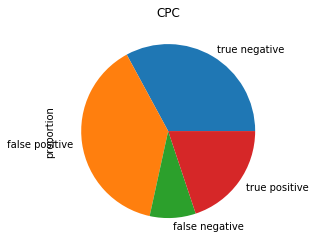

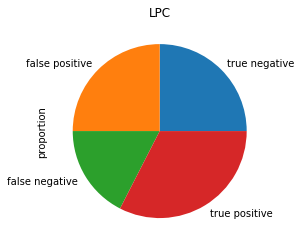

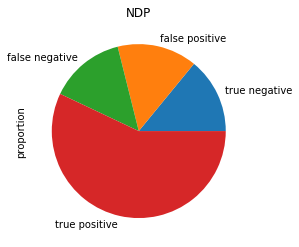

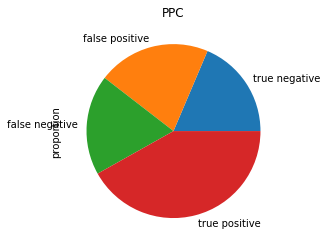

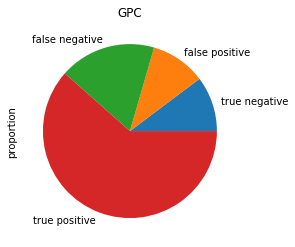

In [93]:
pd.DataFrame(data=confusion_matrix(dfelect['y_true'][dfelect.party=='cpc'], dfelect['y_pred'][dfelect.party=='cpc']).reshape(-1,1), index=['true negative', 'false positive', 'false negative', 'true positive'], 
             columns=['proportion']).plot.pie(y='proportion', legend=False)
plt.title('CPC')
print('CPC test accuracy: {}%'.format(accuracy_score(dfelect['y_true'][dfelect.party=='cpc'], 
                                                 dfelect['y_pred'][dfelect.party=='cpc'])*100))

pd.DataFrame(data=confusion_matrix(dfelect['y_true'][dfelect.party=='lpc'], dfelect['y_pred'][dfelect.party=='lpc']).reshape(-1,1), index=['true negative', 'false positive', 'false negative', 'true positive'], 
             columns=['proportion']).plot.pie(y='proportion', legend=False)
plt.title('LPC')
print('LPC test accuracy: {}%'.format(accuracy_score(dfelect['y_true'][dfelect.party=='lpc'], 
                                                 dfelect['y_pred'][dfelect.party=='lpc'])*100))

pd.DataFrame(data=confusion_matrix(dfelect['y_true'][dfelect.party=='ndp'], dfelect['y_pred'][dfelect.party=='ndp']).reshape(-1,1), index=['true negative', 'false positive', 'false negative', 'true positive'], 
             columns=['proportion']).plot.pie(y='proportion', legend=False)
plt.title('NDP')
print('NDP test accuracy: {}%'.format(accuracy_score(dfelect['y_true'][dfelect.party=='ndp'], 
                                                 dfelect['y_pred'][dfelect.party=='ndp'])*100))

pd.DataFrame(data=confusion_matrix(dfelect['y_true'][dfelect.party=='ppc'], dfelect['y_pred'][dfelect.party=='ppc']).reshape(-1,1), index=['true negative', 'false positive', 'false negative', 'true positive'], 
             columns=['proportion']).plot.pie(y='proportion', legend=False)
plt.title('PPC')
print('PPC test accuracy: {}%'.format(accuracy_score(dfelect['y_true'][dfelect.party=='ppc'], 
                                                 dfelect['y_pred'][dfelect.party=='ppc'])*100))

pd.DataFrame(data=confusion_matrix(dfelect['y_true'][dfelect.party=='gpc'], dfelect['y_pred'][dfelect.party=='gpc']).reshape(-1,1), index=['true negative', 'false positive', 'false negative', 'true positive'], 
             columns=['proportion']).plot.pie(y='proportion', legend=False)
plt.title('GPC')
print('GPC test accuracy: {}%'.format(accuracy_score(dfelect['y_true'][dfelect.party=='gpc'], 
                                                 dfelect['y_pred'][dfelect.party=='gpc'])*100))
plt.show()

Observe that the model performs worst with the CPC affiliated tweets. It performs much better on the smaller parties tweets than the LPC or CPC. Recall that we've seen that CPC are associated with the most negative tweets with *Scandal* being the most prominent reason. Our hypothesis is that the scandal discussing tweets use specific words that are not used frequently in negative day-to-day tweets. As such, the model might predict their sentiment to be positive since it was not trained on these words. If you look at the first pie chart representing the confusion matrix of the CPC tweets, this is evident from how large the false positives portion is. 

Let's predict the election results from the model's sentiments prediction and compare it to the actual results. The method is very naive and crude, however, we'll assume that the 5 parties considered will share the vote (which is not the case since you have other parties that weren't considered, most notably the Bloc), and that every positive tweet corresponds to a vote for the party. We then normalize the data to a 100 votes to visualize it. The good things we get is that the more positive tweets associated with a party, the more the people speaking well of the party and the more votes it is likely to get. If a party's tweets are mostly positive, but not many people are speaking about it, it is not likely to get many votes. These two points will be accounted for even with this crude method.

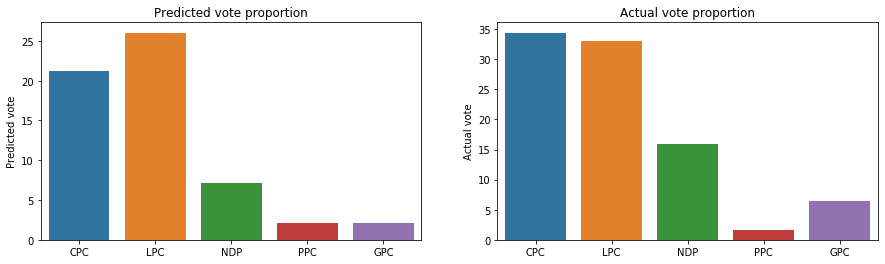

In [94]:
elxn_pred = [sum(dfelect['y_pred'][dfelect.party=='cpc'])/4,
             sum(dfelect['y_pred'][dfelect.party=='lpc'])/4,
             sum(dfelect['y_pred'][dfelect.party=='ndp'])/4,
             sum(dfelect['y_pred'][dfelect.party=='ppc'])/4,
             sum(dfelect['y_pred'][dfelect.party=='gpc'])/4]
elxn_pred=pd.DataFrame(data=np.divide(elxn_pred,sum(dfelect['y_pred'])/4)*100, columns=['Predicted vote'], 
                              index=['CPC', 'LPC', 'NDP', 'PPC', 'GPC'])
elxn_pred['Actual vote'] = [34.4, 33.1, 15.9, 1.6, 6.5]
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.barplot(data=elxn_pred, y='Predicted vote', x=elxn_pred.index)
plt.title('Predicted vote proportion')
plt.subplot(1, 2, 2)
sns.barplot(data=elxn_pred, y='Actual vote', x=elxn_pred.index)
plt.title('Actual vote proportion')
plt.show()

The bar charts above show the predicted election results using the LR and the actual election results. The actual results had CPC leading with number of votes, but LPC leading with number of electoral districts. 

We can interpret a few things from the predicted results:
- The election will be decided between CPC and LPC with the elected party not having majority government (which happened)
- LPC leads (kind of happened but with electoral districts instead of votes)
- NDP will be the third (happened)

NLP has helped us predict most of the important results of the election, even with a relatively weak classifier. 

#### How can we improve the accuracy?

In [95]:
pd.DataFrame(data=np.unique(dfelect['party'], return_counts=True)[1], index=np.unique(dfelect['party'], return_counts=True)[0])

,0
cpc,468
gpc,39
lpc,584
ndp,128
other,871
ppc,43


1) The dataframe above shows the number of tweets for each party. The number of tweets labelled other is so much. We can improve our model by determining whether these tweets can be labelled with a party so that more tweets can be used in training.

2) We can increase the training dataset by including more generic tweets. A larger training set means less overfit which can increase our test accuracy.

3) Train the model on tweets from a political tweets set, whether from a previous election or the US elections, to capture the effect of politically specific words.

4) Increase the weight of positive tweets to neutralize some the positive skeweness.

Let's see next if NLP can help a party determine the concerns of the people by training a model on the negative reasons of political tweets.

## 8. Sentiment Negative Reason Classification

In this section, we compare LR, Linear SVM and Naive Bayes for the task of predicting the negative reason of a tweet. The only change to the negative reasons that we'll make is replacing NaN entries in the column with 'Others'. We'll also use TF-IDF vecorizing to define the input features. **For bonus**, we'll again tune our model parameters and use the best model.

In [96]:
dfelect = dfelect.drop(columns=['y_true', 'y_pred'])

In [97]:
df = dfelect[dfelect['sentiment'] == 'negative']

In [98]:
np.unique(df.negative_reason)

array(['Climate Problem', 'Economy', 'Healthcare',
       'Healthcare and Marijuana', 'Others', 'Privilege', 'Scandal',
       'Separation', 'Tell lies', 'Women Reproductive right and Racism'],
      dtype=object)

In [99]:
X = tfidf(df)
y = df.negative_reason
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

The best model is LR classifier with L1 penalty and C=25. Let's continue with LR and test it out via 10 fold cross validation.

In [100]:
from sklearn.model_selection import cross_val_score
clf = LogisticRegression(penalty='l1', dual=False, 
                         tol=0.0001, C=25, fit_intercept=True, 
                         intercept_scaling=1, class_weight=None, 
                         random_state=43, solver='liblinear', max_iter=100, 
                         multi_class='auto', verbose=0, warm_start=False, 
                         n_jobs=None, l1_ratio=None)

In [101]:
cross_val = cross_val_score(clf, X, y, cv=10, n_jobs=-1)

In [102]:
print(np.mean(cross_val).round(decimals=2)*100)

56.00000000000001


We have achieved a 57% accuracy on average. In the last section, we'll discuss the findings of the research.

#### Why is the accuracy this low?

1) One reason seems that the training set is just too small, that the LR classifier overfits. The cell below calculates the training accuracy to be a high 99.86% which supports this hypothesis. 

In [106]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print('training accuracy: {}'.format(accuracy_score(y_train, y_pred)))

training accuracy: 0.9985795454545454


2) There might be overlap between the words used in tweets having different negative reasons which might make it hard for a model to separate between. For example, below is the confusion matrix of the model testing. Anything on the diagonal is a correct prediction while off-diagonals were wrong predictions on the model's part. Tell lies and Scandal seem overlapping reasons for us, and from the matrix, we can also see that the model made a few mistakes labelling a scandal discussing tweet as a tell lies and vice-versa - 8 here and there.

3) 'Others' was a very frequent label, and indeed by far the most frequent of the labels. The model might have been skewed to make more 'Others' predictions during training as a result. Also there might be overlap between 'Others' and some of the other labels, which is again apparent from the confusion matrix, with 22 scandal and 13 tell lies tweets mislabelled 'Others'. 

In [144]:
y_pred = clf.predict(X_val)
df = pd.DataFrame(data=y_val)
df['y_pred'] = y_pred

pd.DataFrame(data=confusion_matrix(df.negative_reason, df['y_pred'], labels= np.unique(y_pred)),
             index=np.unique(y_pred), columns=np.unique(y_pred))

,Climate Problem,Economy,Healthcare and Marijuana,Others,Privilege,Scandal,Separation,Tell lies,Women Reproductive right and Racism
Climate Problem,5,0,0,3,0,1,0,1,0
Economy,0,6,0,6,1,3,0,3,0
Healthcare and Marijuana,0,0,0,1,0,0,0,0,0
Others,0,0,1,76,1,22,1,13,1
Privilege,0,1,0,0,0,0,0,0,0
Scandal,0,1,0,40,1,38,0,8,4
Separation,0,0,0,2,0,0,1,0,0
Tell lies,0,0,0,18,0,8,0,27,1
Women Reproductive right and Racism,0,0,0,3,0,0,0,1,3


#### How can we improve the accuracy?

1) We can increase the training dataset by including more tweets. A larger training set means less overfit which can increase our test accuracy. 

2) Merge between similar negative reasons.

3) Reduce the label 'Others' in the training set.
## 9. Discussion

## What can public opinion on Twitter tell us about the Canadian political landscape in 2019?

In this research we used a set of web-scraped tweets to study the public opinion on the Internet ahead of the 2019 Canadian Federal elections. Early on, we saw how visualizing the text and hashtags used in the tweets can help us identify the main issues that can be deciding factors in the elections. We saw how KinsellaGate was trending when it came to discussing the Conservatives party, and we were able to pin-point out the slogans of the parties from wordclouds, such as the Liberal's "ChooseForward". The data visualization unfortunately also showed that the public opinion held both Conservatives and Liberals as scandilicious liars, undermining more important issues such as Healthcare, Environment and Economy. 

It would be interesting to study tweets from last elections to see how the public opionion concerning the Liberals and the Conservatives has changed since, and what were the trending issues last time.

We then trained a ML Logistic Regression classifier on a dataset of generic tweets and saw that it helped us predict correctly the most important results of the elections, including that the minority government would be Liberal, and that the Conservatives would act as the Queen's opposition. 

While very powerful, we also saw that the vocabulary of generic tweets can be very different from that which is used during elections in political tweets. This can skew a classifier which was only trained on the generic tweets vocabulary, leading to a classifier which stands to improve alot more. Evident from this was that the classifier performed better on predicting the sentiment of tweets referencing smaller parties in Canada such as PPC, NDP and GPC, most likely due to the fact that the vocabulary use in these tweets is less-specific and more generic. To improve the model's overall accuracy, we suggested using larger training sets, which also include in them a good fraction of political tweets. 

In conclusion, we saw that Natural Language Processing can be very helpful in determining political opinion on the Internet, to an extent which makes them very important to use during polling. 